## Gradient Boosting: Personality Dataset
Introvert and Extrovert personality test.

In [6]:
!pip install xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time

Read from Google Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 1: Data Preparation

In [13]:
# Load dataset
df = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/personality_dataset_extra.csv')

df

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4,No,8.0,5.0,Extrovert
...,...,...,...,...,...,...,...,...
2895,3.0,No,7.0,6,No,6.0,6.0,Extrovert
2896,3.0,No,8.0,3,No,14.0,9.0,Extrovert
2897,4.0,Yes,1.0,1,Yes,4.0,0.0,Introvert
2898,11.0,Yes,1.0,3,Yes,2.0,0.0,Introvert


In [14]:
df.shape

(2900, 8)

This dataset has some missing values

For the columns with object values, we replace the missing values with mode, and for the columns with numerical values, we replace the missing values with median.

In [15]:
# Select object columns
object_columns = df.select_dtypes(include=['object']).columns
# Select numerical columns
num_columns = df.select_dtypes(include=['number']).columns
# Replace the object columns with mode
# In case there are multiple modes, select the first mode found
df[object_columns] = df[object_columns].fillna(df[object_columns].mode().iloc[0])
# Replace the number columns with median
df[num_columns] = df[num_columns].fillna(df[num_columns].median())

Check if there are still missing values

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2900 non-null   float64
 1   Stage_fear                 2900 non-null   object 
 2   Social_event_attendance    2900 non-null   float64
 3   Going_outside              2900 non-null   int64  
 4   Drained_after_socializing  2900 non-null   object 
 5   Friends_circle_size        2900 non-null   float64
 6   Post_frequency             2900 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 181.4+ KB


In [17]:
# Return the stastical description
df.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000
mean,4.505816,3.963354,3.000000,6.268863,3.564727
std,3.441180,2.872608,2.221597,4.232340,2.893587
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,3.963354,3.000000,5.000000,3.000000
75%,7.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


Turn categorical variables to numerical (for example: True/False is replaced by 1/0

In [18]:
# Replacing categorical variables
object_columns = df.select_dtypes(include=['object']).columns
for i in object_columns:
    unique_values = df[i].unique()
    df[i] = df[i].map({unique_values[value]: value for value in range(len(unique_values))})

### Step 2: Data Splitting

Split the data into training set and testing set

In [19]:
# Split the data into 80% for training and 20% for testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training samples: {train_df.shape[0]}, Testing samples: {test_df.shape[0]}")

Training samples: 2320, Testing samples: 580


Get features and target

In [20]:
# Features and Target
target = 'Personality'
features = df.columns.drop(target)
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

### Step 3: Model Training

Gradient Boosting (GB) is an ensemble learning technique that builds a strong model by combining many weak learners, usually decision trees.

It works sequentially, which means each new model learns from the errors of the previous ones. This is like training a team of robots where each robot improves on the mistakes of the last, resulting in a highly accurate final model.

In each step, Gradient Boosting uses gradient descent to minimize a loss function (e.g., mean squared error or cross-entropy). The process continues until the model reaches the desired accuracy or a stopping condition is met.

Gradient Boosting does *not* immediately start with a Decision Tree. Before any tree is trained, Gradient Boosting begins with a **simple initial prediction**, often just a **constant value** that minimizes the loss function.

After this constant model, Gradient Boosting trains the **first decision tree** to fit the **residuals (errors)** from that initial base prediction, *not* the original labels. Even if the original problem is **classification**, the next learner (the first tree) in **Gradient Boosting** is usually a **regression tree** — not a classifier.

===== Basic Gradient Boosting =====
Training Time: 0.2703883647918701 seconds
Accuracy: 0.9293103448275862
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       302
           1       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580



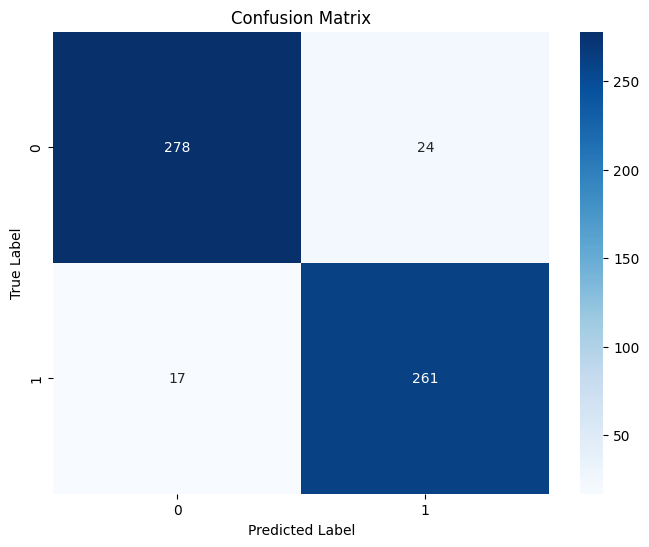

In [21]:
# Gradient Boosting
print("===== Basic Gradient Boosting =====")
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Start timer
start_time = time.time()

gb_model.fit(X_train, y_train)

# End timer
end_time = time.time()

# Calculate training time
training_time_gb = end_time - start_time
print(f"Training Time: {training_time_gb:} seconds")


gb_pred = gb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, gb_pred)}")
print("Classification Report:")
print(classification_report(y_test, gb_pred))

unique_labels = df[target].unique()
# Confusion Matrix
cm1 = confusion_matrix(y_test, gb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, cmap="Blues", fmt="g",
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
# Get staged prediction
staged_pred = list(gb_model.staged_predict_proba(X_test))

# Read as dataframe
df_list = []
for stage_idx, arr in enumerate(staged_pred):
    temp_df = pd.DataFrame(arr, columns=[f"class_{c}" for c in range(arr.shape[1])])
    temp_df["stage"] = stage_idx
    df_list.append(temp_df)

staged_pred_df = pd.concat(df_list, ignore_index=True)
staged_pred_df = staged_pred_df.set_index('stage')

staged_pred_df

,class_0,class_1
stage,,
0,0.461727,0.538273
0,0.553773,0.446227
0,0.464807,0.535193
0,0.474334,0.525666
0,0.474334,0.525666
...,...,...
99,0.958108,0.041892
99,0.120939,0.879061
99,0.195383,0.804617


XGBoost, or Extreme Gradient Boosting. An improvement from Gradient Boosting that also starts training the first learner with a stump, weak tree and improve gradually. But:
- The model also utilizes the L1/L2 Regression to cope with overfitting.
- Handles missing data and sparse features efficiently.
- Can build trees faster than traditional Gradient Boosting.
- Learning rate ($\eta$) and feature subsampling improve generalization.

===== XGBoost =====
Training Time: 0.0985405445098877 seconds
Accuracy: 0.9293103448275862
AUC: 0.9598301491257325
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       302
           1       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580



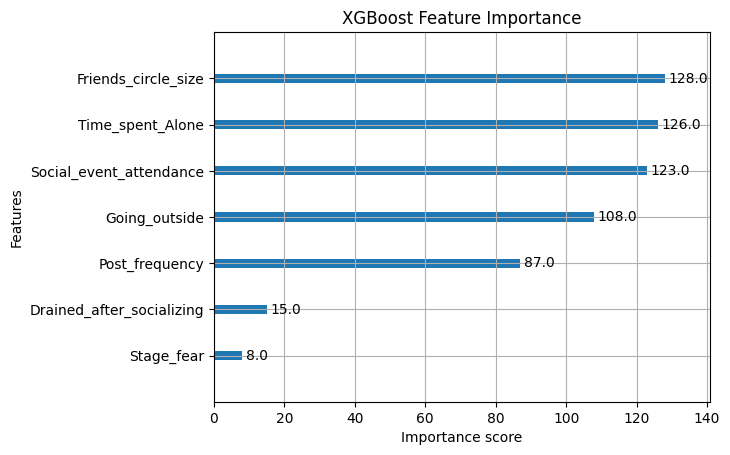

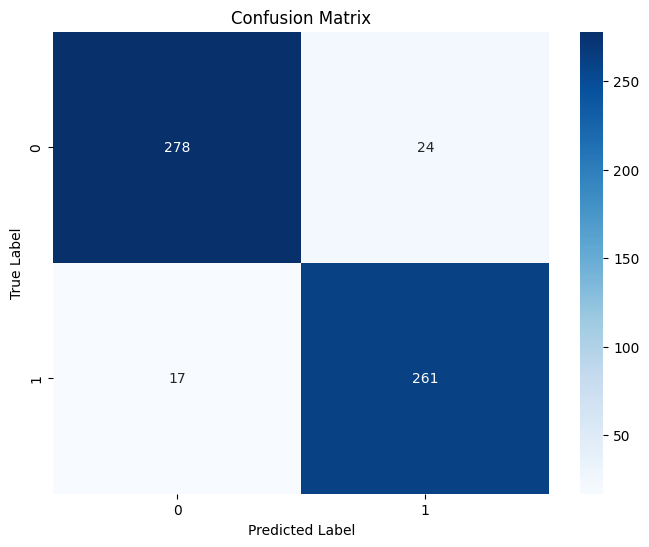

In [29]:
# XGBoost Implementation
# Start timer
start_time = time.time()

print("===== XGBoost =====")
xgb_model = xgb.XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3,
    subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="logloss"
)
xgb_model.fit(X_train, y_train)

# End timer
end_time = time.time()

# Calculate training time
training_time_xgb = end_time - start_time
print(f"Training Time: {training_time_xgb:} seconds")

xgb_pred = xgb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, xgb_pred)}")
print(f"AUC: {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])}")
print("Classification Report:")
print(classification_report(y_test, xgb_pred))

# Feature importance
xgb.plot_importance(xgb_model)
plt.title("XGBoost Feature Importance")
plt.show()

unique_labels = df[target].unique()

# Confusion Matrix
cm2 = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, cmap="Blues", fmt="g",
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

LightGBM, or Light Gradient Boosting Machine, is another Gradient Boosting method that uses tree-based learning algorithm.

- Instead of computing residuals sample-to-sample like traditional gradient boosting, but only leaf-wise, focus on those samples with the highest errors.
- It is designed to be **fast, memory-efficient, and scalable,** especially for very large datasets.
- Overfitting on small datasets, but exceptionally powerful with large datasets.

The following code call the using the core (native) API to run the LightGBM model.

lgb.LGBMClassifier().fit(X, y) is the Scikit-Learn API, for easier, sklearn-compatible model training

===== LightGBM =====
Training Time: 0.3497579097747803 seconds
Accuracy: 0.9293103448275862
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       302
           1       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580



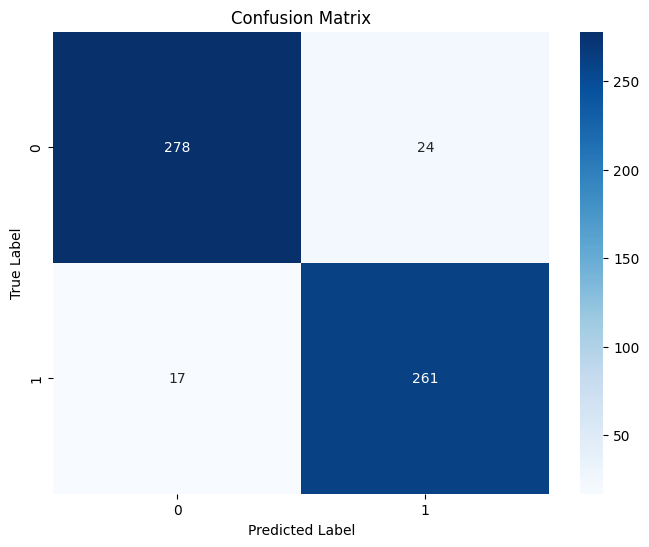

In [30]:
# LightGBM Implementation
# Start timer
start_time = time.time()
print("===== LightGBM =====")
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'learning_rate': 0.1,
    'max_depth': 3,
    'num_leaves': 7,
    'verbose': -1
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=100,
                      valid_sets=lgb_test)

# End timer
end_time = time.time()
# Calculate training time
training_time_lgb = end_time - start_time
print(f"Training Time: {training_time_lgb:} seconds")

lgb_pred = lgb_model.predict(X_test)
lgb_pred_binary = [1 if p > 0.5 else 0 for p in lgb_pred]
print(f"Accuracy: {accuracy_score(y_test, lgb_pred_binary)}")
print("Classification Report:")
print(classification_report(y_test, lgb_pred_binary))

unique_labels = df[target].unique()

# Confusion Matrix
cm3 = confusion_matrix(y_test, lgb_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, cmap="Blues", fmt="g",
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

CatBoost, stands for Categorical Boosting, a gradient boosting model for categorical variables.

- It omits the one-hot encoding or label encoding process and handle the categorical variables natively.
- Creates a symmetric tree, all leaves at the same depth, resulting in more stable predictions

===== CatBoost =====
Training Time: 0.15136146545410156 seconds
Accuracy: 0.9293103448275862
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       302
           1       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580



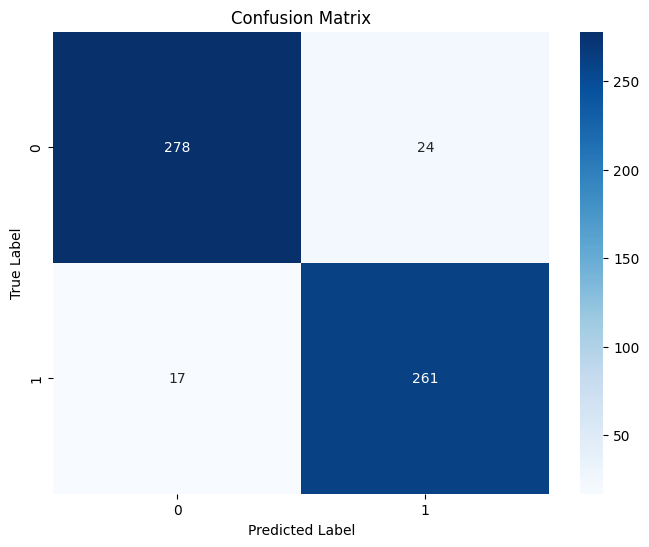

In [31]:
# CatBoost Implementation
# Start timer
start_time = time.time()

print("===== CatBoost =====")
cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

# End timer
end_time = time.time()

# Calculate training time
training_time_cb = end_time - start_time
print(f"Training Time: {training_time_cb:} seconds")

cat_pred = cat_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, cat_pred)}")

print("Classification Report:")
print(classification_report(y_test, cat_pred))

unique_labels = df[target].unique()

# Confusion Matrix
cm3 = confusion_matrix(y_test, cat_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, cmap="Blues", fmt="g",
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [32]:
# Compare Models
results = {
    "Gradient Boosting": accuracy_score(y_test, gb_pred),
    "XGBoost": accuracy_score(y_test, xgb_pred),
    "LightGBM": accuracy_score(y_test, lgb_pred_binary),
    "CatBoost": accuracy_score(y_test, cat_pred)
}
print("\n===== Model Accuracy Comparison =====")
for name, acc in results.items():
    print(f"{name:<20}: {acc:.4f}")


===== Model Accuracy Comparison =====
Gradient Boosting   : 0.9293
XGBoost             : 0.9293
LightGBM            : 0.9293
CatBoost            : 0.9293


Since XGBoost and Gradient Boosting produce a really similar result, so a training time is necessary to make sure we are not accidentally using a same model.

In [33]:
print("\n===== Model Training Time Comparison =====")
print(f"Gradient Boosting: {training_time_gb:.2f} seconds")
print(f"XGBoost: {training_time_xgb:.2f} seconds")
print(f"LightGBM: {training_time_lgb:.2f} seconds")
print(f"CatBoost: {training_time_cb:.2f} seconds")


===== Model Training Time Comparison =====
Gradient Boosting: 0.27 seconds
XGBoost: 0.10 seconds
LightGBM: 0.35 seconds
CatBoost: 0.15 seconds


Visualize the metrics

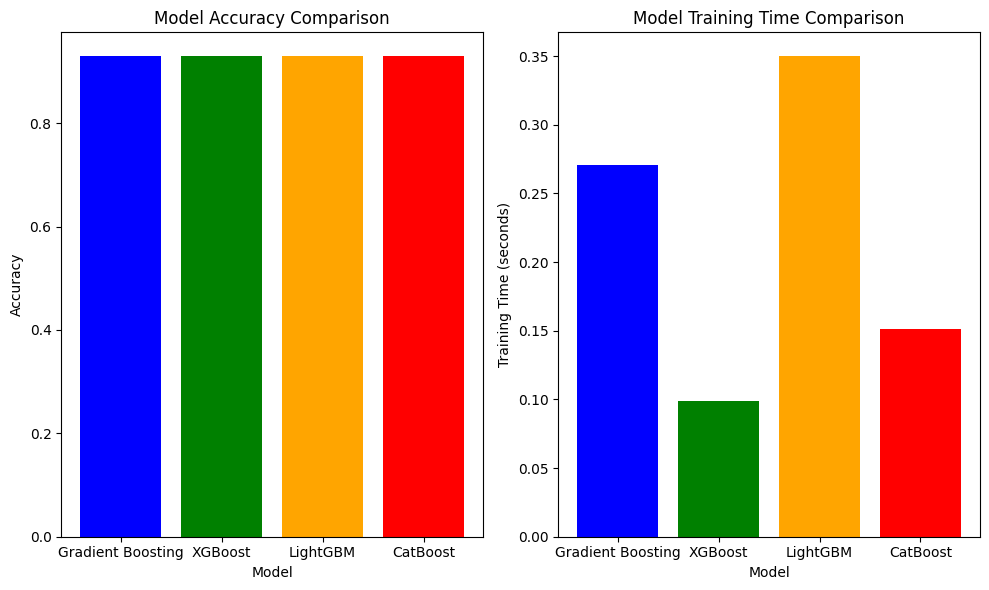

In [34]:
# Visualize the metrics and model training time
models = ["Gradient Boosting", "XGBoost", "LightGBM", "CatBoost"]
accuracies = [accuracy_score(y_test, gb_pred),
              accuracy_score(y_test, xgb_pred),
              accuracy_score(y_test, lgb_pred_binary),
              accuracy_score(y_test, cat_pred)]
training_times = [training_time_gb, training_time_xgb, training_time_lgb, training_time_cb]
# Plot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.subplot(1, 2, 2)
plt.bar(models, training_times, color=['blue', 'green', 'orange', 'red'])
plt.title("Model Training Time Comparison")
plt.xlabel("Model")
plt.ylabel("Training Time (seconds)")
plt.tight_layout()
plt.show()


In [35]:
# Model Representation (Conceptual)
print("\nEach model stores:")
print("→ A series of small decision trees (weak learners)")
print("→ A learning rate controlling their contribution")
print("→ The final model is an additive ensemble:")
print("   F(x) = Σ (η * γ_m * h_m(x))")


Each model stores:
→ A series of small decision trees (weak learners)
→ A learning rate controlling their contribution
→ The final model is an additive ensemble:
   F(x) = Σ (η * γ_m * h_m(x))


They can easily reach similar accuracy if:

- You use the same data,

- Similar hyperparameters (like learning rate, number of trees, max depth),

- And the dataset isn’t too large or complex.

This is the end of the notebook, if you have any suggestions let us know